In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import wavfile
import ruptures as rpt


In [3]:
audio_file = (
    "/Users/daniel/Desktop/WD_cse_project/NC-Simulation/VID_20240103_125230_MONO.wav"
)
sample_rate, audio_array = wavfile.read(audio_file)
time_array = np.arange(0, len(audio_array)) / sample_rate

In [4]:
# Print some info about the audio.
print("Sample rate:", sample_rate)
print("Number of channels:", audio_array.ndim)
print("Total samples:", len(audio_array))
print("Duration:", len(audio_array) / sample_rate, "seconds")

Sample rate: 48000
Number of channels: 1
Total samples: 5584896
Duration: 116.352 seconds


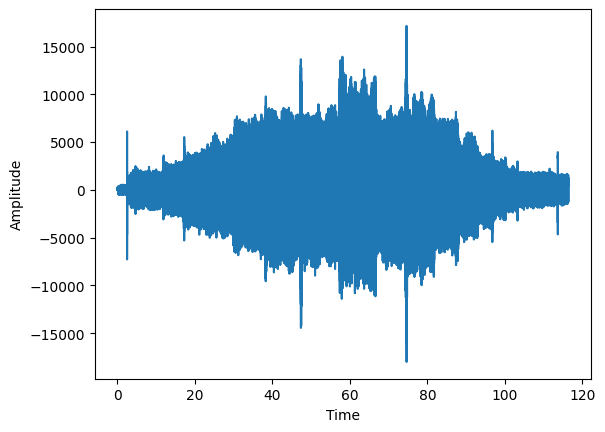

In [5]:
# Print signal over time.
plt.plot(time_array,audio_array)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

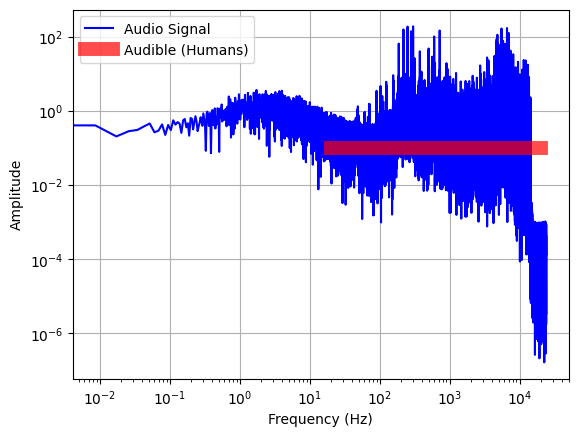

In [6]:
# analyze entire audio clip
na = len(audio_array)
a_k = np.fft.fft(audio_array)[0 : int(na / 2)] / na  # FFT function from numpy
a_k[1:] = 2 * a_k[1:]  # single-sided spectrum only
Pxx = np.abs(a_k)  # remove imaginary part
f = sample_rate * np.arange((na / 2)) / na  # frequency vector

# plotting
fig, ax = plt.subplots()
plt.plot(f, Pxx, "b-", label="Audio Signal")
plt.plot(
    [20, 20000], [0.1, 0.1], "r-", alpha=0.7, linewidth=10, label="Audible (Humans)"
)
ax.set_xscale("log")
ax.set_yscale("log")
plt.grid()
plt.legend()
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.show()

/var/folders/kf/77r2jlj11cdb300p1by5h4900000gn/T/ipykernel_93347/2634699807.py:2: RuntimeWarning: divide by zero encountered in log
  lspg = np.log(spgram)


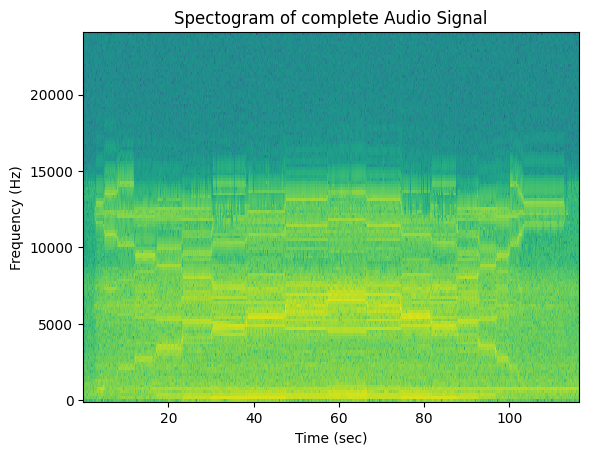

In [7]:
fr, tm, spgram = signal.spectrogram(audio_array, sample_rate)
lspg = np.log(spgram)
plt.pcolormesh(tm, fr, lspg, shading="auto")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (sec)")
plt.title("Spectogram of complete Audio Signal")
plt.show()

In [8]:
change_points = 19
min_size = 200
algo = rpt.KernelCPD(min_size=min_size).fit(spgram.T)
bkps = algo.predict(n_bkps=change_points)

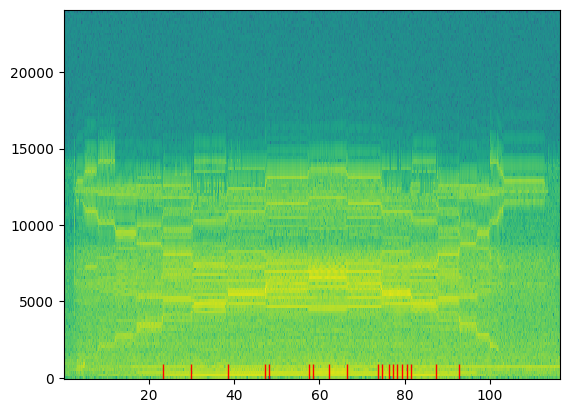

In [9]:
a = tm[bkps[:-1]]
b = np.zeros_like(tm[bkps[:-1]])
plt.pcolormesh(tm, fr, lspg, shading="auto")
plt.plot(a,b,"r|",markersize=20)
plt.show()

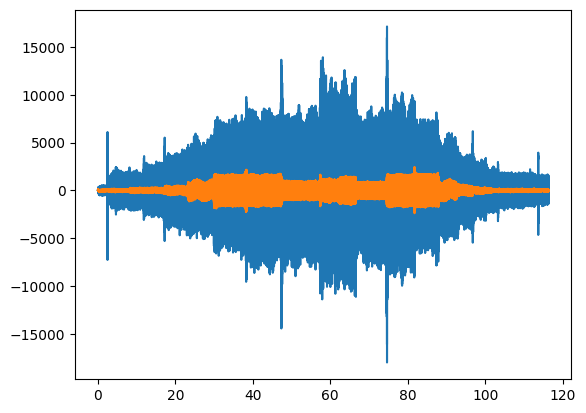

In [18]:
def gaussian_kernel(n=5):
  x = np.arange(n)/n
  g = np.exp(-(x**2/((n - 2)**2))) # drop the constant factor at the start
  return g/g.sum() # normalise so it sums to 1

def gaussian_smooth(x, n=5, passes=2):
  for _ in range(passes):
    x = np.convolve(x, gaussian_kernel(n),mode="same")
  return x

smoothed = gaussian_smooth(audio_array, n=51, passes=5)
plt.plot(time_array, audio_array)
plt.plot(time_array, smoothed)

In [28]:
change_points = 19
min_size = 200
algo = rpt.KernelCPD(min_size=min_size).fit(smoothed)
bkps = algo.predict(n_bkps=change_points)

In [ ]:
a = tm[bkps[:-1]]
b = np.zeros_like(tm[bkps[:-1]])
plt.pcolormesh(tm, fr, lspg, shading="auto")
plt.plot(a,b,"r|",markersize=20)
plt.show()

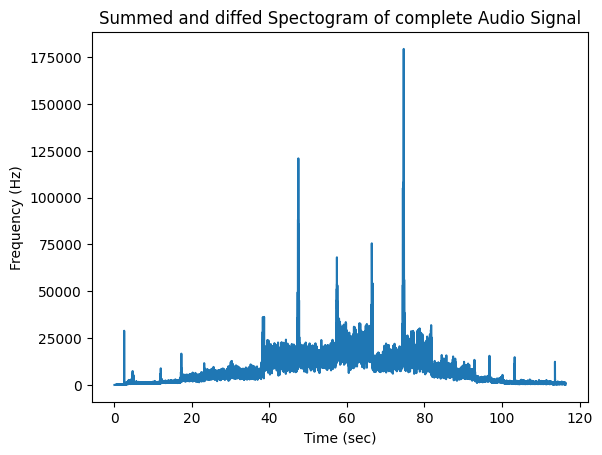

In [11]:
diffed = np.diff(spgram,append=spgram[:,-1].reshape(-1,1))
diffed = np.abs(diffed)
summed = np.sum(diffed,axis=0)
plt.plot(tm,summed)
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (sec)")
plt.title("Summed and diffed Spectogram of complete Audio Signal")
plt.show()

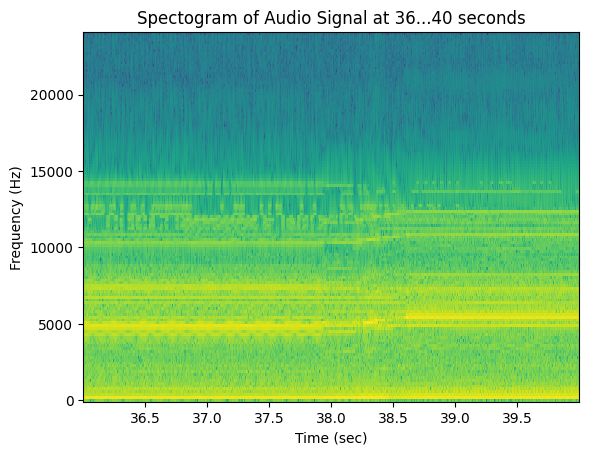

In [12]:
offset = 36
duration = 4
fr, tm, spgram = signal.spectrogram(
    audio_array[offset * sample_rate : (duration + offset) * sample_rate],
    sample_rate,
    window=("tukey", 0.1),
)
lspg = np.log(spgram)
plt.pcolormesh(offset + tm, fr, lspg, shading="auto")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (sec)")
plt.title(f"Spectogram of Audio Signal at {offset}...{offset+duration} seconds")
plt.show()

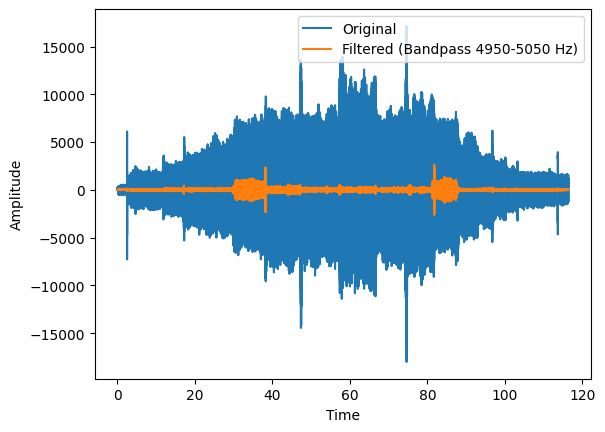

In [13]:
def bandpass(data: np.ndarray, edges: list[float], sample_rate: float, poles: int = 5):
    sos = signal.butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data)
    return filtered_data

# Apply a 10-50 Hz high-pass filter to the original data
low = 4950#4500
high = 5050#5500
filtered = bandpass(audio_array, [low,high], sample_rate)

# Plot the original and filtered signals
plt.plot(time_array,audio_array, label='Original')
plt.plot(time_array,filtered, label=f'Filtered (Bandpass {low}-{high} Hz)')
plt.legend(loc='upper right')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()